In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os

# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 



In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7013/static/


In [43]:
original_intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=80.0, fy=80.0,
    cx=50.0, cy=50.0,
    near=0.001, far=6.0
)

intrinsics = b.scale_camera_parameters(original_intrinsics, 0.5)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 10
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/100.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)


In [44]:
b.RENDERER.model_box_dims

Array([[1.0888801, 1.7841201, 0.3667   ]], dtype=float32)

In [45]:
num_frames = 120



poses = [b.t3d.transform_from_pos(jnp.array([-1.0, -1.0, 4.0]))]
delta_pose = b.t3d.transform_from_rot_and_pos(
    R.from_euler('zyx', [1.0, -0.1, -2.0], degrees=True).as_matrix(),
    jnp.array([0.03, 0.02, 0.04])
)
for t in range(num_frames-1):
    poses.append(poses[-1].dot(delta_pose))
poses = jnp.stack(poses)
print("Number of frames: ", poses.shape[0])

observed_images = b.RENDERER.render_many(poses[:,None,...],  jnp.array([0]))
print("observed_images.shape", observed_images.shape)

translation_deltas = b.utils.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 11, 11, 11)
rotation_deltas = jax.vmap(lambda key: b.distributions.gaussian_vmf_zero_mean(key, 0.00001, 800.0))(
    jax.random.split(jax.random.PRNGKey(3), 500)
)

likelihood = jax.vmap(b.threedp3_likelihood_old, in_axes=(None, 0, None, None, None, None, None))

def update_pose_estimate(pose_estimate, gt_image):
    proposals = jnp.einsum("ij,ajk->aik", pose_estimate, translation_deltas)
    rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:,None, ...], jnp.array([0]))
    weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    pose_estimate = proposals[jnp.argmax(weights_new)]

    proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:, None, ...], jnp.array([0]))
    weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    pose_estimate = proposals[jnp.argmax(weights_new)]

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, translation_deltas)
    # rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:,None, ...], jnp.array([0]))
    # weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    # rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:, None, ...], jnp.array([0]))
    # weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, translation_deltas)
    # rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:,None, ...], jnp.array([0]))
    # weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    # rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:, None, ...], jnp.array([0]))
    # weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, translation_deltas)
    # rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:,None, ...], jnp.array([0]))
    # weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    # rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:, None, ...], jnp.array([0]))
    # weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]
    return pose_estimate, pose_estimate

inference_program = jax.jit(lambda p,x: jax.lax.scan(update_pose_estimate, p,x)[1])
inferred_poses = inference_program(poses[0], observed_images)

start = time.time()
pose_estimates_over_time = inference_program(poses[0], observed_images)
end = time.time()
print ("Time elapsed:", end - start)
print ("FPS:", poses.shape[0] / (end - start))


max_depth = 10.0
rerendered_images = b.RENDERER.render_many(pose_estimates_over_time[:, None, ...], jnp.array([0]))
viz_images = []
for (r, d) in zip(rerendered_images, observed_images):
    viz_r = b.viz.scale_image(b.viz.get_depth_image(r[:,:,2]), 5.0)
    viz_d = b.viz.scale_image(b.viz.get_depth_image(d[:,:,2]), 5.0)
    overlay = b.viz.overlay_image(viz_r,viz_d)
    viz_images.append(b.viz.multi_panel(
        [
            viz_d, viz_r, overlay
        ],
        ["Ground Truth", "Inferred Reconstruction", "Overlay"],
    ))

b.make_gif_from_pil_images(viz_images, "demo.gif")

Number of frames:  120
observed_images.shape (120, 50, 50, 4)
Time elapsed: 1.4676568508148193
FPS: 81.7629815398456


In [32]:
b.make_gif_from_pil_images(viz_images, "demo.gif")

In [33]:
b.show_trimesh("1", b.RENDERER.meshes[0])

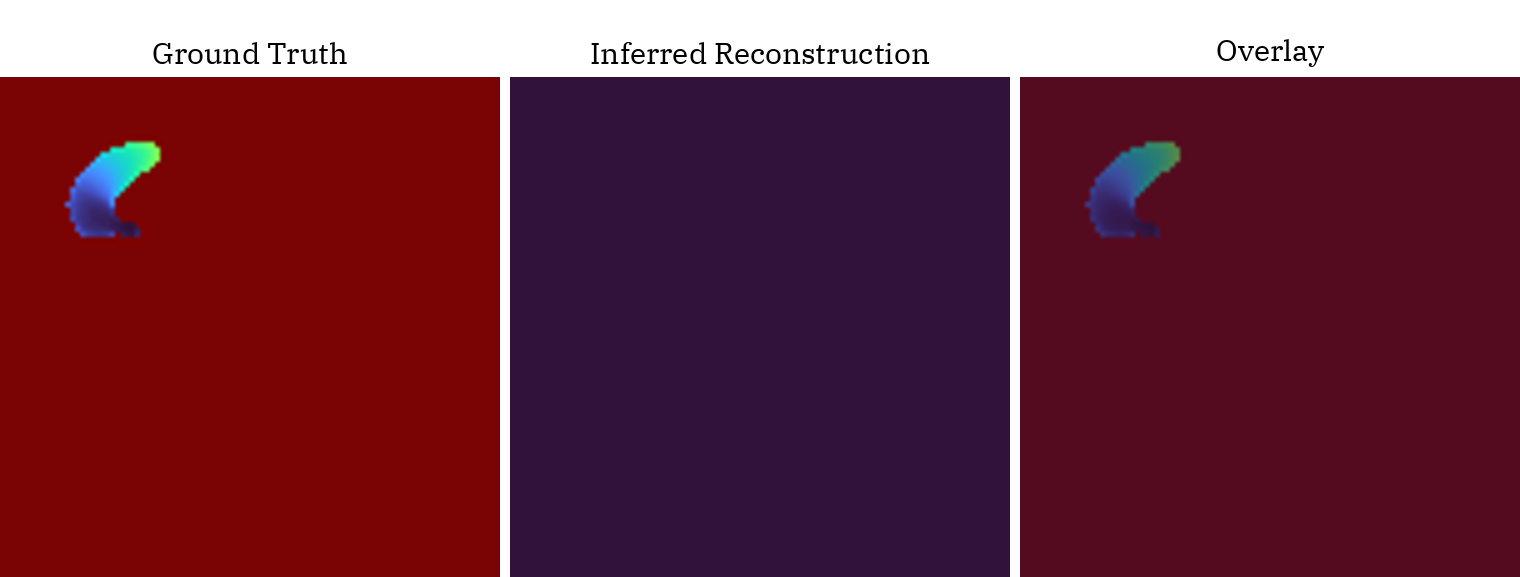

In [34]:
viz_images[24].convert("RGB")

In [4]:
assert len(poses) == len(pose_estimates_over_time)
b.clear()
for (i,p) in enumerate(poses):
    b.show_pose(f"{i}", p,size=0.05)
    # b.show_pose(f"{i}_pred", inferred_poses[i],size=0.1)

In [5]:
assert len(poses) == len(pose_estimates_over_time)
for (i,p) in enumerate(poses):
    b.show_pose(f"{i}_pred", inferred_poses[i],size=0.1)

In [6]:
b.make_gif_from_pil_images([v.convert("RGB") for v in viz_images], "demo.gif")

ValueError: Could not save to JPEG for display

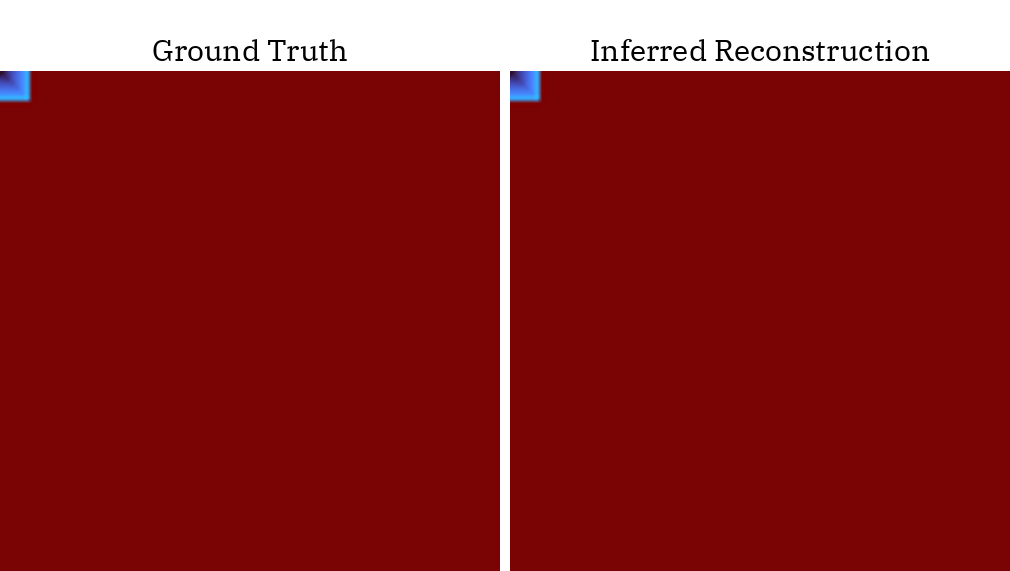

In [7]:
b.viz.load_image_from_file("demo.gif")

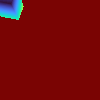

In [8]:
b.get_depth_image(observed_images[10,:,:,2])